# Test some things with Brunel's model

## For Brunel's model

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.axislines import Subplot
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../')) # include path with style
sys.path.append(os.path.abspath('../brunel_simulation/')) # include path with simulation specifications
import style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import brunel_model_class as model_class; reload(model_class)

%matplotlib inline

save_fig = False
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
colors = style.colors

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 6 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


## Mean field model solution:

In [2]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=False, method=root_method, options=options)
    if sol["success"]:
        return sol["x"]
    else:   
        raise Exception("No solution found for v_guess_0")
        
def CV_ISI_mf(v0, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import dblquad
    from scipy.special import erf
    mu     = model.mu(v0)
    sd     = model.sd(v0)
    lows   = (model.V_r - mu) / sd
    ups    = (model.theta - mu) / sd
    bounds = np.array([lows, ups]).T

    # Double integral
    def func(u, x):
        if u < -4.0:
            return np.exp(x**2) * \
                np.exp(-u**2) / np.sqrt(np.pi) * (u**-2
                                                    - u**-4
                                                    + 7.0 * u**-6 / 4.0
                                                    - 9.0 * u**-8 / 2.0)
        else:
            return np.exp(x**2) * np.exp(u**2) * (1. + erf(u))**2

    gfun = lambda x: -np.inf
    hfun = lambda x: x
    dbl_integral  = np.array([dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)[0]
                                   for low, up in bounds])

    cv_theo = np.sqrt(2 * np.pi * v0**2 * dbl_integral * model.tau_m**2) # Define as sd / mean, NOT var / mean**2
    return cv_theo

In [3]:
def plot_compare_sim_mf(data_sim, data_mf, ax, marker="+", hatch=None, legend_suffix="psc"):
    y_mf = np.arange(n_populations) + 0.1
    yticks = np.arange(n_populations) + 0.5
    if reverse_order:
        y_mf = y_mf[::-1]
        yticks = yticks[::-1]
    bar_height = 0.8 

    for i, population in enumerate(populations):
        ax.plot(data_sim[:, i], [yticks[i]]*rates_mean_all.shape[0], marker, color=colors[i], mew=2, ms=20)
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                color=colors[i], linewidth=0, fill=True, alpha=0.3, hatch=hatch) 
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                edgecolor=colors[i], linewidth=2, fill=False, alpha=1.0) 
    ax.barh([0], [0], color="lightgray", edgecolor="darkgray", 
            linewidth=2, fill=True, alpha=1.0, label="mean field, " + legend_suffix, hatch=hatch) 
    ax.plot([-1], [0], marker, color="gray", alpha=1.0, label="simulated, " + legend_suffix, mew=2, ms=5) 

    yticklabels = hf.rlbl(populations)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

delta [[ 13.915  13.871]] [ 14.09903666  14.09903666]
exp [[ 14.051   13.9554]] [ 13.58810961  13.58810961]


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


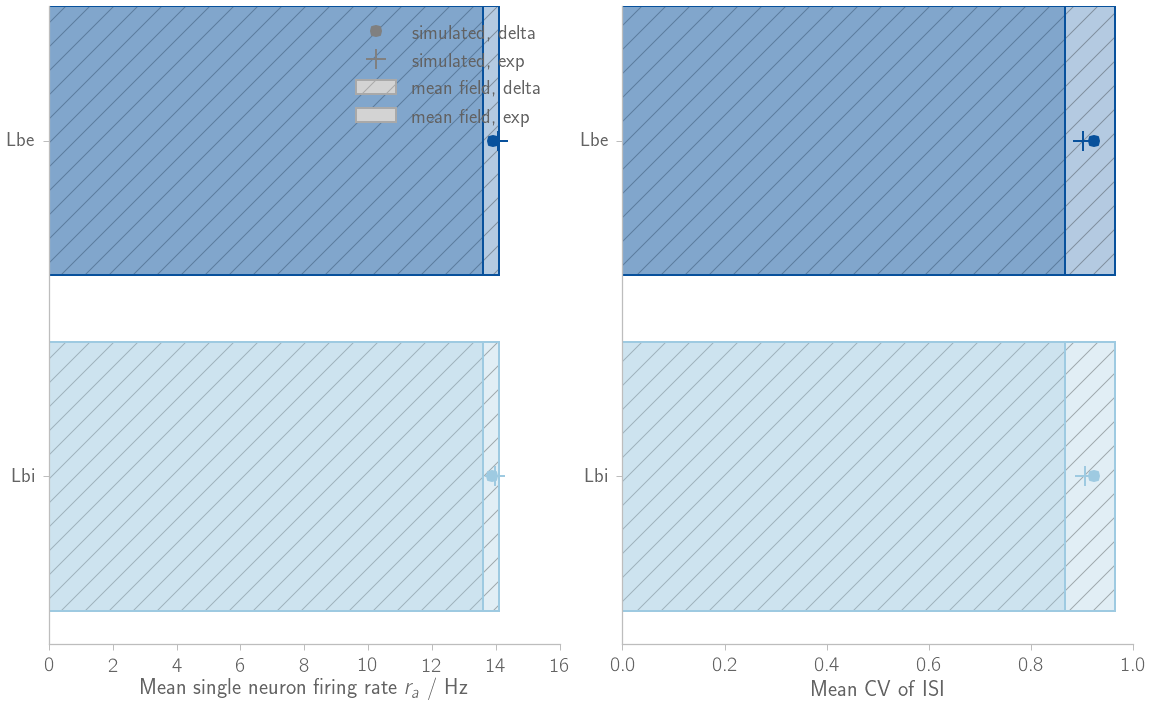

In [4]:
sim_spec_sub = "test_brunel_C1"
data_path = "/users/schuessler/uni/microcircuit/data/brunel" 
    
synapse_models    = ["delta", "exp"]
markers = [".", "+"]
hatches = ["/", None]

fig = plt.figure()
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for k, synapse_model in enumerate(synapse_models):
    neuron_model = "iaf_psc_" + synapse_model

    ######################################################
    # Mean field results
    ######################################################
    connection_rule = "fixed_indegree"
    weight_rel_sd   = 0.0
    model     = model_class.model(neuron_model=neuron_model,
                                        connection_rule=connection_rule, 
                                        weight_rel_sd=weight_rel_sd) 

    v_guess_0       = np.array([ 35, 35])
    root_method='hybr'
    options= {"xtol": 1e-13, "maxfev": 10**3}

    rate_mf     = solve_model(model, v_guess_0,
                              root_method=root_method, options=options)

    cv_isi_mf   = CV_ISI_mf(rate_mf, model=model)

    ######################################################
    # Simulation results
    ######################################################
    # DATA
    sim_spec = sim_spec_sub + "_" + synapse_model
    res_file_name = sim_spec + "_res.hdf5"
    path_res_file = os.path.join(data_path, res_file_name)

    (area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    with h5py.File(path_res_file, "r") as res_file:
        n_sims = len(res_file.keys())

        rates_mean_all  = np.zeros((n_sims, n_populations))
        cv_isi_mean_all = np.zeros((n_sims, n_populations))
        for j, sim_spec2 in enumerate(res_file.keys()):  
            res_grp = res_file[sim_spec2]
            rates_mean_all[j]   = res_grp["rates_mean"][:]
            cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]

    print(synapse_model, rates_mean_all, rate_mf)
    ######################################################
    # Plotting
    ######################################################
    plot_compare_sim_mf(rates_mean_all, rate_mf, ax1, markers[k], hatch=hatches[k], legend_suffix=synapse_model)
    plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2, markers[k], hatch=hatches[k], legend_suffix=synapse_model)


ax1.set_xlabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_xlim(0,)
ax1.legend(loc="best")

ax2.set_xlabel("Mean CV of ISI")
ax2.set_xlim(0, 1)

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_brunel"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

delta [[ 13.6894  13.9066]] [ 14.09903666  14.09903666]
exp [[ 13.9566  14.1066]] [ 13.58810961  13.58810961]


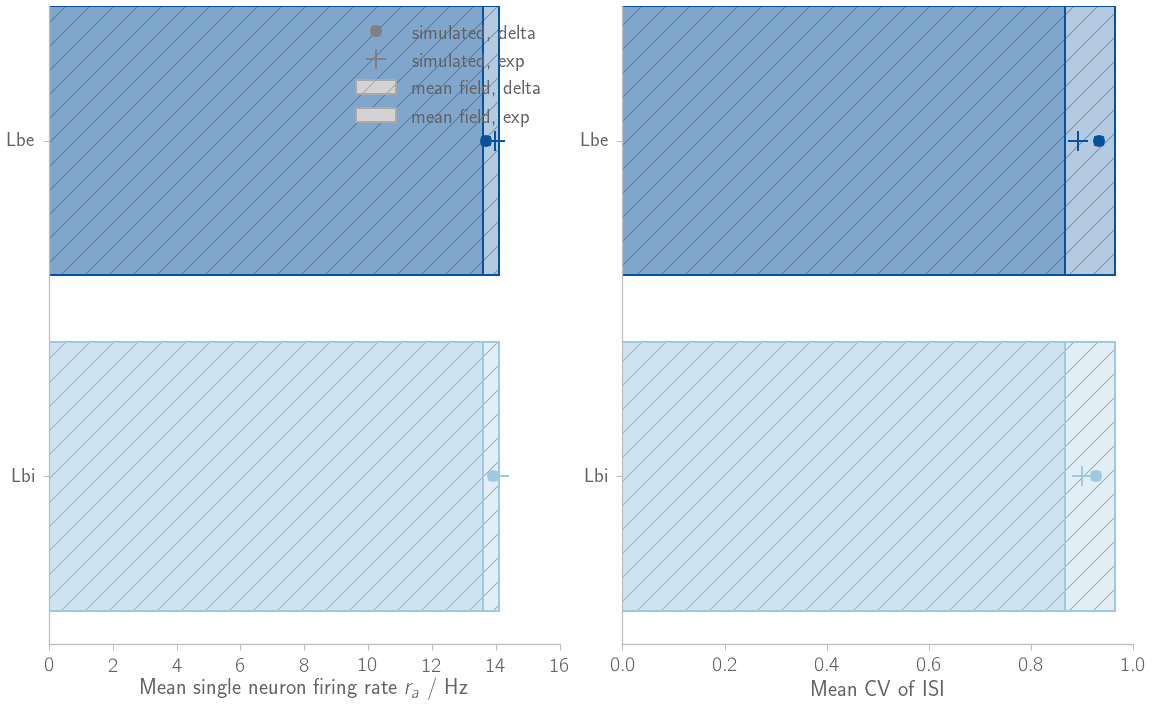

In [33]:
sim_spec_sub = "test_brunel_C250"
data_path = "/users/schuessler/uni/microcircuit/data/brunel" 
    
synapse_models    = ["delta", "exp"]
markers = [".", "+"]
hatches = ["/", None]

fig = plt.figure()
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for k, synapse_model in enumerate(synapse_models):
    neuron_model = "iaf_psc_" + synapse_model

    ######################################################
    # Mean field results
    ######################################################
    connection_rule = "fixed_indegree"
    weight_rel_sd   = 0.0
    model     = model_class.model(neuron_model=neuron_model,
                                        connection_rule=connection_rule, 
                                        weight_rel_sd=weight_rel_sd) 

    v_guess_0       = np.array([ 35, 35])
    root_method='hybr'
    options= {"xtol": 1e-13, "maxfev": 10**3}

    rate_mf     = solve_model(model, v_guess_0,
                              root_method=root_method, options=options)

    cv_isi_mf   = CV_ISI_mf(rate_mf, model=model)

    ######################################################
    # Simulation results
    ######################################################
    # DATA
    sim_spec = sim_spec_sub + "_" + synapse_model
    res_file_name = sim_spec + "_res.hdf5"
    path_res_file = os.path.join(data_path, res_file_name)

    (area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    with h5py.File(path_res_file, "r") as res_file:
        n_sims = len(res_file.keys())

        rates_mean_all  = np.zeros((n_sims, n_populations))
        cv_isi_mean_all = np.zeros((n_sims, n_populations))
        for j, sim_spec2 in enumerate(res_file.keys()):  
            res_grp = res_file[sim_spec2]
            rates_mean_all[j]   = res_grp["rates_mean"][:]
            cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]

    print(synapse_model, rates_mean_all, rate_mf)
    ######################################################
    # Plotting
    ######################################################
    plot_compare_sim_mf(rates_mean_all, rate_mf, ax1, markers[k], hatch=hatches[k], legend_suffix=synapse_model)
    plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2, markers[k], hatch=hatches[k], legend_suffix=synapse_model)


ax1.set_xlabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_xlim(0,)
ax1.legend(loc="best")

ax2.set_xlabel("Mean CV of ISI")
ax2.set_xlim(0, 1)

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_brunel"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

# Not tested ...

In [3]:
def prob_V(V_array, mu_i, sd_i, v0_i, model=model_class.model()):
    """Membrane potential probability distribution P(V_m) according to Brunel"""
    from scipy.integrate import quad
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand
    
    Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)
  
    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals
    
    return step(-Vs + model.theta) * P_V_array

In [4]:
def theo_membrane_potential(mu_i, sd_i, rate_i, model):
    V_min       = -100
    V_max       = model.E_L + model.theta
    n_bins_volt = 500
    V_step = (V_max - V_min) / n_bins_volt
    V_array = np.arange(V_min, V_max, V_step)

    P_V_theo = prob_V(V_array, mu_i, sd_i, rate_i, model=model)
        
    return V_array, P_V_theo, V_step

        
def plot_membrane_potential(V_array, P_V_theo, model, 
                            figsize=(xfactor*6.2, 2*xfactor*3.83), 
                            figname="membrane_potential"):
    # Figure
    fig = plt.figure(figsize=figsize)
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ymax = 0.17 # max height for each population
    V_range_plot = [V_min, V_array[-1] + 1]
    # Labels
    marker_sim = "-"
    marker_mf  = "-"
    #ax1.plot([0, 0], [0, 0], marker_sim, color="gray", label="simulated") 
    #ax1.plot([0, 0], [0, 0], marker_mf, color="gray", label="mean field", linewidth=3.0)

    for i, population in enumerate(populations):
        # Plotting
        if reverse_order:
            offset = (n_populations - (i + 1)) * ymax
        else:
            offset = i * ymax
        ax1.plot(V_array, P_V_theo[i] + offset, marker_mf, linewidth=3.0, color=colors[i])
        ax1.plot(V_range_plot, [offset]*2, "-.", color="gray") # line indicating P = 0

    # Resting potential and treshhold
    #ax1.plot([model.E_L + model.theta]*2, [0, n_populations * ymax], 
    #         "--", linewidth=1.5, color="gray", zorder=0 )#, label="$\\theta$")
    ax1.plot([model.E_L]*2, [0, n_populations * ymax], 
             "-.", linewidth=2, color="gray", alpha=0.5, zorder=0 )#, label="$E_L$")
    
    # Axes label, etc.
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_ylim(0, n_populations * ymax)
    ax1.set_xlim(*V_range_plot)
    ax1.grid(False)
    ax1.legend(loc='best')

    # Create ticks manually
    n_ticks = 4
    ytickmax = ymax - 0.01
    yto           = np.arange(0, ytickmax, ytickmax/n_ticks)
    yt_offset     = np.repeat(np.arange(0,  n_populations * ymax, ymax), n_ticks)
    y_ticks = np.tile(yto, n_populations) + yt_offset
    y_ticklabels = np.tile(yto, n_populations)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)   


    for ax in fig.axes:
        style.fixticks(ax)
    
    # Population labels
    ax2 = ax1.twinx()
    ax2.set_ylabel('Population')
    ax2.set_yticks(np.arange(0.5, 8, 1)* ymax) 
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax2.set_yticklabels(yticklabels)
    ax2.set_ylim(0, n_populations * ymax)
    ax2.yaxis.set_ticks_position('none') 
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.grid(False)
        
    fig_name = "membrane_potential"
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name, verbose=False)  

### What does $\mu$ and $\sigma$ correspond to?
Could both be deduced from measurements of $V_m$?

It appears not to be the case: 

>>$\mu$ grows much faster than $V_m$, there is no bound induced by $\theta$.

>>$\sigma$ is at least not directly comparable to $\mathrm{Var}(V_m)$.

In [7]:
n_factors = 10
factors = np.linspace(1.0, 3.0, n_factors)
V_means = np.zeros(n_factors)
V_sds = np.zeros(n_factors)
mus = np.zeros(n_factors)
sds = np.zeros(n_factors)

print("Pop.\trate\t<V>\tmu\tsd(V)\tsigma")
for rate_ext_factor in factors:
    model              = model_class.model(rate_ext_factor=rate_ext_factor) 
    v_guess_0       = np.array([ 2,  2])

    t_int0      = time.time()
    rate_mf = solve_model(model, v_guess_0)
    t_int1      = time.time() - t_int0
    #print("Integration time: %.2f"%(t_int1))
    
    populations = model.populations
    n_populations = model.n_populations

    # Input according to Brunel
    mu   = model.mu(rate_mf)
    sd   = model.sd(rate_mf)

    i=0
    P_V_theo_all = []
    V_array, P_V_theo, dV = theo_membrane_potential(mu[i], sd[i], rate_mf[i], model=model)

    V_mean = np.dot(V_array, P_V_theo) * dV
    V_var  = np.dot(V_array**2, P_V_theo) * dV - V_mean**2
    V_sd   = np.sqrt(V_var)

    V_means[i] = V_mean
    V_sds[i]   = V_sd
    mus[i] = mu[i]
    sds[i] = sd[i]
    
    print("{0:s}\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}\t{5:.2f}".format(
            populations[i], rate_mf[i], V_mean - model.E_L, V_sd, mu[i], sd[i]))

#    P_V_theo_all.append(P_V_theo)
# plot_membrane_potential(V_array, P_V_theo_all, model=model, 
#                         figsize=(xfactor*6.2, 2*xfactor*3.83), figname="membrane_potential")

Pop.	rate	<V>	mu	sd(V)	sigma
Lbe	3.66	4.61	6.06	5.38	9.42
Lbe	5.10	2.97	6.99	4.03	11.10
Lbe	6.45	1.74	7.73	3.07	12.47
Lbe	7.75	0.75	8.35	2.34	13.65
Lbe	9.01	-0.09	8.90	1.74	14.72
Lbe	10.24	-0.82	9.39	1.26	15.69
Lbe	11.46	-1.47	9.83	0.84	16.59
Lbe	12.65	-2.05	10.24	0.50	17.43
Lbe	13.84	-2.58	10.62	0.20	18.23
Lbe	15.01	-3.06	10.98	-0.06	18.98


# CV of ISI for Brunel

In [18]:
def CV_ISI_mf(mu_i, sd_i, v0_i, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import quad
    from scipy.special import erf
    low   = (model.V_r - mu_i) / sd_i
    up    = (model.theta - mu_i) / sd_i

    def integrand(u):
        if u < -4.0:
            return np.exp(-u**2) / np.sqrt(np.pi) * (1.0 / u**2 - 
                                                     1.0 / u**4 + 
                                                     7.0 / (4.0 * u**6) - 
                                                     9.0 / (2.0 * u**8))
        else:
            return np.exp(u**2) * (1. + erf(u))**2
    
    def outer_integrand(x):
        return np.exp(x**2) * quad(integrand, -np.inf, x)
    
    def outer_integral(lower, upper):
        return quad(outer_integrand, lower, upper)
    
    CVs = 2 * np.pi * v0_i**2 * outer_integral(low, up) 
    
    return CVs

0	0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899
1	0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899
2	0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899


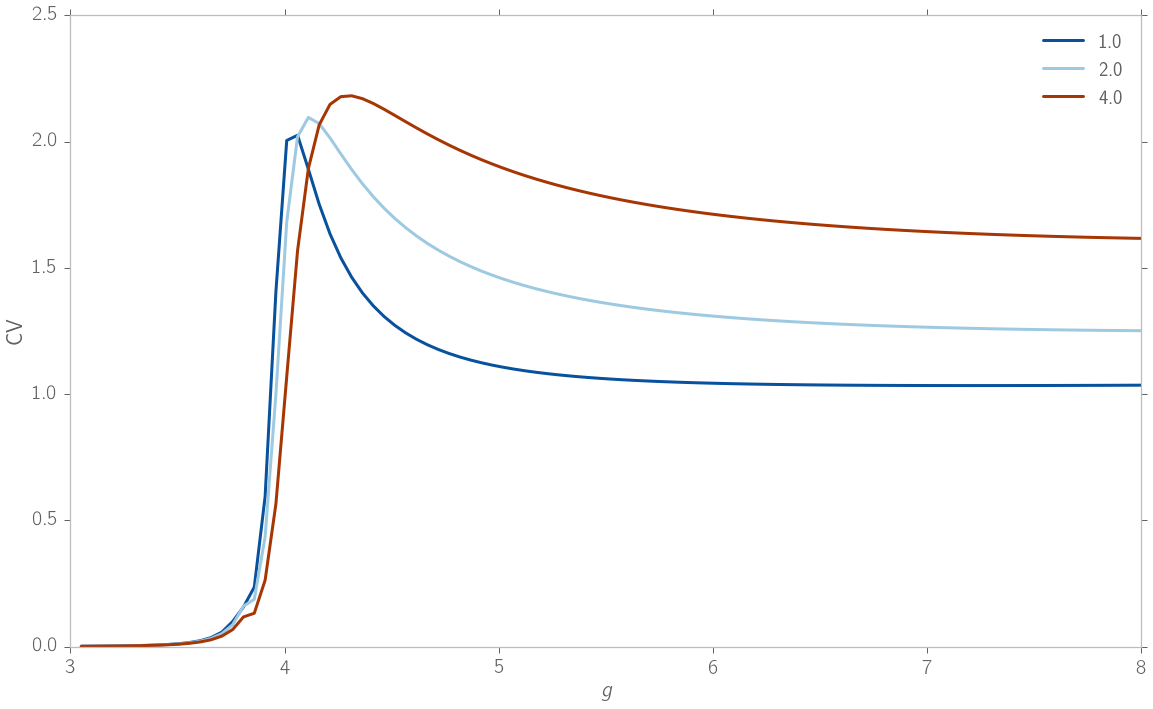

In [78]:
from scipy.integrate import quad, dblquad
from scipy.special import erf

factors = [1., 2., 4.]
gs      = np.linspace(3, 8, 100)
cvs     = np.zeros((len(factors), len(gs)))

for k, rate_ext_factor in enumerate(factors):
    print(k, end="\t")
    for j, g in enumerate(gs):
        print(j, end="")

        # Model
        model              = model_class.model(g=g, rate_ext_factor=rate_ext_factor) 
        v_guess_0          = np.array([ 2,  2])
        rate_mf            = solve_model(model, v_guess_0)

        populations        = model.populations
        n_populations      = model.n_populations

        # Input according to Brunel
        mu   = model.mu(rate_mf)
        sd   = model.sd(rate_mf)

        #for i in range(n_populations):
        i = 0 # population
        
        mu_i = mu[i]
        sd_i = sd[i]
        v0_i = rate_mf[i]

        low   = (model.V_r - mu_i) / sd_i
        up    = (model.theta - mu_i) / sd_i

        # Double integral
        def func(u, x):
            if u < -4.0:
                return np.exp(x**2) * \
                    np.exp(-u**2) / np.sqrt(np.pi) * (u**-2
                                                        - u**-4
                                                        + 7.0 * u**-6 / 4.0
                                                        - 9.0 * u**-8 / 2.0)
            else:
                return np.exp(x**2) * np.exp(u**2) * (1. + erf(u))**2

        gfun = lambda x: -np.inf
        hfun = lambda x: x
        dbl_integral, derr = dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)

        cv_theo = 2 * np.pi * v0_i**2 * dbl_integral * model.tau_m**2
        
        cvs[k, j] = cv_theo
        
    print("")
    #     print(loint)
    #     print(outint)
    #     print(dbl_integral)
#         print("{0:.0f}{1:6.2f}{2:12.2f}".format(rate_ext_factor, g, cv_theo))

# Plotting


fig = plt.figure()
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)


for k, rate_ext_factor in enumerate(factors):
    ax1.plot(gs, cvs[k], 
             "-", linewidth=3., color=colors[k], label=str(rate_ext_factor))
#     ax1.plot([low]*2, [min(y_plot), max(y_plot)], 
#              "--", linewidth=1., color="lightgray")
#     ax1.plot([up]*2, [min(y_plot), max(y_plot)], 
#              "--", linewidth=1., color="lightgray")

# Axes label, etc.
ax1.set_xlabel('$g$')
ax1.set_ylabel('CV')
#ax1.set_ylim(-5, 10)
ax1.grid(False)
ax1.legend(loc='best')
